In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=6942a74bd63b457ff1b1b1d56385dad518a632d4a840ab3ecadcf3910ea09f33
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3B: Style Transfer

### Cristian Barraza, Carla Velásquez

### Ayudante: Giovanni Castiglioni
### Profesor: Pablo Estévez

# Metodología

1.   Función de pérdida
2.   Pre-procesamiento de imágenes
3.   Autoencoders pre-entrenados





In [13]:
#IMPORTS
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import IPython
import PIL
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt


# Función de pérdida

$$
L=||I_o-I_i||_2^2+\lambda ||\Phi (I_o)-\Phi(I_i)||_2^2
$$

Se implementa como clase y como función.

In [5]:
class Custom_Loss(nn.Module):
    def __init__(self, l):
        super().__init__()
        self.loss=nn.MSELoss()
        self.L=l

    def forward(self, im_in, im_out, fm_in, fm_out):
        return self.loss(im_in,im_out)+self.L*self.loss(fm_in,fm_out)

def CustomLoss(L,im_in,im_out,fm_in,fm_out):
        loss=nn.MSELoss(reduction='sum')
        return loss(im_in,im_out) + L*loss(fm_in,fm_out)

# Pre-procesamiento de imágenes

Se usa COCO dataset 2017 (conjunto de testeo) porque es un intermedio en los tamaños de los archivos

In [6]:
# Usando link (demora más)
# if not Path('test2017.zip').is_file():
#   !wget http://images.cocodataset.org/zips/test2017.zip
#   !unzip 'test2017.zip'

# Usando archivo en drive
if not Path('test2017').is_dir():
    !unzip 'drive/MyDrive/test2017.zip'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 extracting: test2017/000000251604.jpg  
 extracting: test2017/000000145034.jpg  
 extracting: test2017/000000234833.jpg  
 extracting: test2017/000000025927.jpg  
 extracting: test2017/000000393116.jpg  
 extracting: test2017/000000536478.jpg  
 extracting: test2017/000000365460.jpg  
 extracting: test2017/000000089887.jpg  
 extracting: test2017/000000274928.jpg  
 extracting: test2017/000000310028.jpg  
 extracting: test2017/000000229793.jpg  
 extracting: test2017/000000394339.jpg  
 extracting: test2017/000000564538.jpg  
 extracting: test2017/000000440585.jpg  
 extracting: test2017/000000541512.jpg  
 extracting: test2017/000000395525.jpg  
 extracting: test2017/000000235435.jpg  
 extracting: test2017/000000069964.jpg  
 extracting: test2017/000000131962.jpg  
 extracting: test2017/000000281392.jpg  
 extracting: test2017/000000534893.jpg  
 extracting: test2017/000000128676.jpg  
 extracting: test2017/000000187

In [7]:
folder_dir = Path('test2017')

## WCT

In [8]:
def wct(alpha, cf, sf, s1f=None):
    with torch.no_grad():

      # content image whitening
      cf = cf.double()
      c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
      cfv = cf.view(c_channels, -1)  # c x (h x w)

      c_mean = torch.mean(cfv, 1) # perform mean for each row
      c_mean = c_mean.unsqueeze(1).expand_as(cfv) # add dim and replicate mean on rows
      cfv = cfv - c_mean # subtract mean element-wise

      c_covm = torch.mm(cfv, cfv.t()).div((c_width * c_height) - 1)  # construct covariance matrix
      c_u, c_e, c_v = torch.svd(c_covm, some=False) # singular value decomposition

      k_c = c_channels
      for i in range(c_channels):
          if c_e[i] < 0.00001:
              k_c = i
              break
      c_d = (c_e[0:k_c]).pow(-0.5)

      w_step1 = torch.mm(c_v[:, 0:k_c], torch.diag(c_d))
      w_step2 = torch.mm(w_step1, (c_v[:, 0:k_c].t()))
      whitened = torch.mm(w_step2, cfv)

      # style image coloring
      sf = sf.double()
      _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
      sfv = sf.view(c_channels, -1)

      s_mean = torch.mean(sfv, 1)
      s_mean = s_mean.unsqueeze(1).expand_as(sfv)
      sfv = sfv - s_mean

      s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
      s_u, s_e, s_v = torch.svd(s_covm, some=False)

      s_k = c_channels # same number of channels ad content features
      for i in range(c_channels):
          if s_e[i] < 0.00001:
              s_k = i
              break
      s_d = (s_e[0:s_k]).pow(0.5)

      c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
      c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
      colored = torch.mm(c_step2, whitened)

      cs0_features = colored + s_mean.resize_as_(colored)
      cs0_features = cs0_features.view_as(cf)

      target_features = cs0_features

      ccsf = alpha * target_features + (1.0 - alpha) * cf
      return ccsf.float().unsqueeze(0)

## Visualización de imágenes


In [20]:
# Función para visualizar elementos del dataset

def tensor_imshow(tensor, title=None):
    t=torch.zeros_like(tensor)
    t[0]=tensor[0]*0.00392156862745098+0.48235
    t[1]=tensor[1]*0.00392156862745098+0.45882
    t[2]=tensor[2]*0.00392156862745098+0.40784
    inp = t.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if plt.isinteractive():
        plt.ioff()
    plt.show()

## Dataset

In [10]:
from torch.utils.data import Dataset

class COCO(Dataset):

    def __init__(self, folder_path, transform=None):
        super().__init__()
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        len_dataset = len(list(self.folder_path.glob('**/*.jpg')))
        return len_dataset

    def __getitem__(self, idx):
        image=str(list(self.folder_path.glob('**/*.jpg'))[idx])
        with open(image, 'rb') as file:
          img=Image.open(file).convert('RGB')
          if self.transform is not None:
              img = self.transform(img)
          return img

In [11]:
st_transform = transforms.Compose([
                                  #transforms.ToPILImage(mode='RGB'),
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48235, 0.45882, 0.40784),(0.00392156862745098, 0.00392156862745098, 0.00392156862745098)),
                                    ])


29283 
 4067 
 7320
True


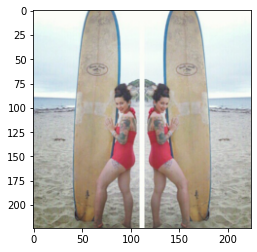

In [12]:
style_transfer_dataset=COCO(folder_dir, st_transform)

# Se hacen los datasets de entrenamiento y testeo
train_size = int(0.9 * len(style_transfer_dataset))
test_size = len(style_transfer_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(style_transfer_dataset, [train_size, test_size])

# Del set de entrenamiento se divide una porción para el set de validación
val_size = int(0.2 * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Se verifican las dimensiones de cada dataset
print(len(train_dataset), '\n', len(test_dataset), '\n', len(val_dataset))
total=len(train_dataset)+len(test_dataset)+len(val_dataset)
print(total==len(style_transfer_dataset))

tensor_imshow(style_transfer_dataset[1000])

## DataLoader y visualización de batch

In [21]:
# DataLoader
train_loader_ejemplo = torch.utils.data.DataLoader(train_dataset, batch_size=25, num_workers=2, pin_memory=True, shuffle=True)

# Visualización de 1 batch
for batch in train_loader_ejemplo:
  for img in batch:
    tensor_imshow(img)
  break


Output hidden; open in https://colab.research.google.com to view.

# Auto encoders

## Encoders (VGG16)

Se usa esta CNN, pero sin sus capas fully connected ya que la idea no es clasificar.

In [ ]:
device = torch.device("cuda")

### Encoder 5 capas

In [ ]:
vgg16_5_capas=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16_5_capas=vgg16_5_capas.features[0:31] # Se quedan sólo las capas convolucionales
vgg16_5_capas.to(device)
vgg16_5_capas.eval();

### Encoder 4 capas

In [ ]:
vgg16_4_capas=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16_4_capas=vgg16_4_capas.features[0:24] # Se quedan sólo 4 bloques convolucionales
vgg16_4_capas.to(device)
vgg16_4_capas.eval();


### Encoder 3 capas

In [ ]:
vgg16_3_capas=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16_3_capas=vgg16_3_capas.features[0:17] # Se quedan sólo 3 capas convolucionales
vgg16_3_capas.to(device)
vgg16_3_capas.eval();


### Encoder 2 capas

In [ ]:
vgg16_2_capas=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16_2_capas=vgg16_2_capas.features[0:10] # Se quedan sólo 2 capas convolucionales
vgg16_2_capas.to(device)
vgg16_2_capas.eval();


### Encoder 1 capa

In [ ]:
vgg16_1_capa=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16_1_capa=vgg16_1_capa.features[0:5] # Se queda sólo 1 capa convolucional
vgg16_1_capa.to(device)
vgg16_1_capa.eval();


## Decoders (VGG16)

Se saca del GitHub y se modifica para que sea VGG16 en vez de VGG19

### Decoder 5 capas

In [ ]:
class Decoder_5_capas(nn.Module):
    def __init__(self):
        super(Decoder_5_capas, self).__init__()
        self.model = nn.Sequential(
            # Bloque 5 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            
            # Bloque 4 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,256,(3, 3)),
            nn.ReLU(),

            # Bloque 3 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,128,(3, 3)),
            nn.ReLU(),

            # Bloque 2 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),

            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

    def forward(self, x):
        #x=torch.permute(x,(0,2,1))
        out = self.model(x)
        return out

### Decoder 4 capas

In [ ]:
class Decoder_4_capas(nn.Module):
    def __init__(self):
        super(Decoder_4_capas, self).__init__()
        self.model = nn.Sequential(        
            # Bloque 4 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,256,(3, 3)),
            nn.ReLU(),

            # Bloque 3 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,128,(3, 3)),
            nn.ReLU(),

            # Bloque 2 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),

            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

    def forward(self, x):
        #x=torch.permute(x,(0,2,1))
        out = self.model(x)
        return out

### Decoder 3 capas

In [ ]:
class Decoder_3_capas(nn.Module):
    def __init__(self):
        super(Decoder_3_capas, self).__init__()
        self.model = nn.Sequential(
            # Bloque 3 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,128,(3, 3)),
            nn.ReLU(),

            # Bloque 2 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),

            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

    def forward(self, x):
        #x=torch.permute(x,(0,2,1))
        out = self.model(x)
        return out

### Decoder 2 capas

In [ ]:
class Decoder_2_capas(nn.Module):
    def __init__(self):
        super(Decoder_2_capas, self).__init__()
        self.model = nn.Sequential(
            # Bloque 2 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),

            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

    def forward(self, x):
        #x=torch.permute(x,(0,2,1))
        out = self.model(x)
        return out

### Decoder 1 capa

In [ ]:
class Decoder_1_capa(nn.Module):
    def __init__(self):
        super(Decoder_1_capa, self).__init__()
        self.model = nn.Sequential(
            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

        # if Path('decoder.pth').is_file():
        #   self.model.load_state_dict(torch.load("decoder.pth"))

    def forward(self, x):
        #x=torch.permute(x,(0,2,1))
        out = self.model(x)
        return out

### Inicialización con pesos

In [ ]:
decoder_5_capas=Decoder_5_capas()
decoder_4_capas=Decoder_4_capas()
decoder_3_capas=Decoder_3_capas()
decoder_2_capas=Decoder_2_capas()
decoder_1_capa=Decoder_1_capa()

In [ ]:
decoder_5_capas.to(device)
decoder_4_capas.to(device)
decoder_3_capas.to(device)
decoder_2_capas.to(device)
decoder_1_capa.to(device);

In [ ]:
decoder_5_capas.eval()
decoder_4_capas.eval()
decoder_3_capas.eval()
decoder_2_capas.eval()
decoder_1_capa.eval();

In [ ]:
decoder_5_capas.load_state_dict(torch.load('/content/drive/MyDrive/decoder5_entrenado_11epoch.pth'))
decoder_4_capas.load_state_dict(torch.load('/content/drive/MyDrive/decoder4_10epochs.pth'))
decoder_3_capas.load_state_dict(torch.load('/content/drive/MyDrive/decoder3_entrenado_7epoch.pth'))
decoder_2_capas.load_state_dict(torch.load('/content/drive/MyDrive/decoder2_2epochs.pth'))
decoder_1_capa.load_state_dict(torch.load('/content/drive/MyDrive/decoder1_2epochs.pth'))

<All keys matched successfully>

# Pruebas autoencoders

## Contenido

In [ ]:
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=True)

## Estilo

In [ ]:
file_dir='drive/MyDrive/starry_night.jpg'
img_estilo=Image.open(file_dir).convert('RGB')

In [ ]:
# Se define un dataset con la imagen de estilo
class estilo(Dataset):

    def __init__(self, file_path, transform=None):
        super().__init__()
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        len_dataset = len(list(self.file_path))
        return len_dataset

    def __getitem__(self, idx):
        image=self.file_path
        with open(image, 'rb') as file:
          img=Image.open(file).convert('RGB')
          if self.transform is not None:
              img = self.transform(img)
          return img

# Se inicializa el DataLoader
style_dataset=estilo(file_dir, st_transform)
style_loader = torch.utils.data.DataLoader(style_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=True)

In [ ]:
alfa=0.5

## CAPA 5

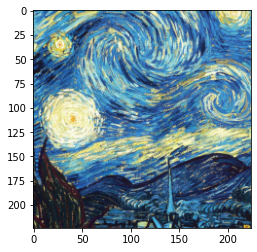

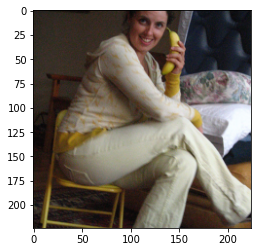

In [ ]:
# Estilo
for batch in style_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_5_estilo=vgg16_5_capas(img)
  break

# Contenido
for batch in test_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_5_contenido=vgg16_5_capas(img)
  break

torch.Size([1, 512, 7, 7])


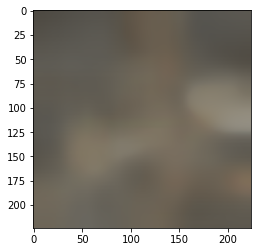

torch.Size([1, 3, 224, 224])

In [ ]:
# WCT
st_5=wct(alfa, features_5_contenido, features_5_estilo);
print(st_5.shape)
# Reconstrucción
recon_5=decoder_5_capas(st_5)
for img_contenido in recon_5:
  tensor_imshow(img_contenido.cpu().detach())

recon_5.shape

## CAPA 4

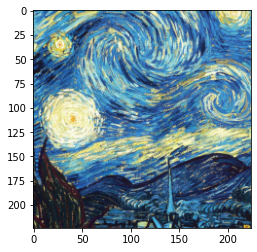

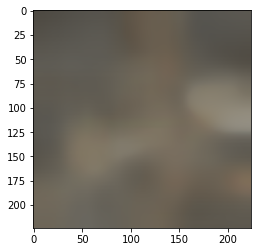

In [ ]:
# Estilo
for batch in style_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_4_estilo=vgg16_4_capas(batch)
  break

# Salida 5
recon_5=recon_5.to(device)
for img in recon_5:
  tensor_imshow(img.cpu().detach())
  features_4_contenido=vgg16_4_capas(recon_5)

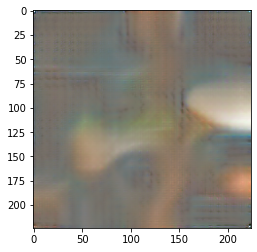

In [ ]:
# WCT
st_4=wct(alfa, features_4_contenido, features_4_estilo)[0];

# Reconstrucción
recon_4=decoder_4_capas(st_4)
for img_contenido in recon_4:
  tensor_imshow(img_contenido.cpu().detach())

## CAPA 3

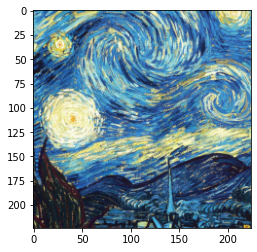

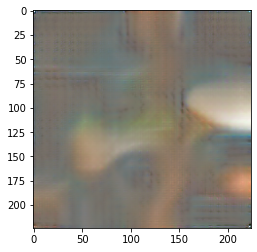

In [ ]:
# Estilo
for batch in style_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_3_estilo=vgg16_3_capas(batch)
  break

# Salida 5

recon_4=recon_4.to(device)
for img in recon_4:
  tensor_imshow(img.cpu().detach())
  features_3_contenido=vgg16_3_capas(recon_4)

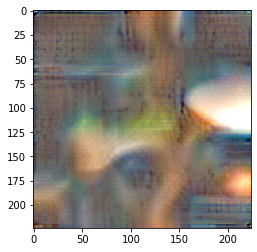

In [ ]:
# WCT
st_3=wct(alfa, features_3_contenido, features_3_estilo)[0];

# Reconstrucción
recon_3=decoder_3_capas(st_3)
for img_contenido in recon_3:
  tensor_imshow(img_contenido.cpu().detach())

## CAPA 2

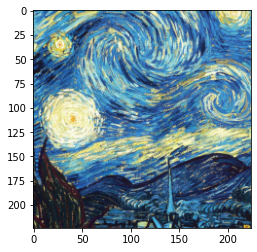

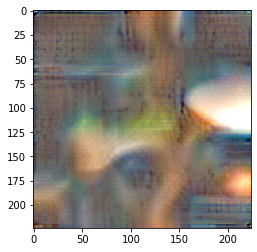

In [ ]:
# Estilo
for batch in style_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_2_estilo=vgg16_2_capas(batch)
  break

# Salida 3

recon_3=recon_3.to(device)
for img in recon_3:
  tensor_imshow(img.cpu().detach())
  features_2_contenido=vgg16_2_capas(recon_3)

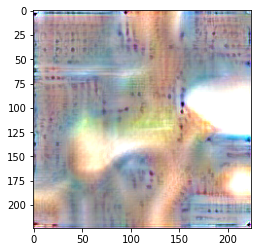

In [ ]:
# WCT
st_2=wct(alfa, features_2_contenido, features_2_estilo)[0];

# Reconstrucción
recon_2=decoder_2_capas(st_2)
for img_contenido in recon_2:
  tensor_imshow(img_contenido.cpu().detach())


## CAPA 1

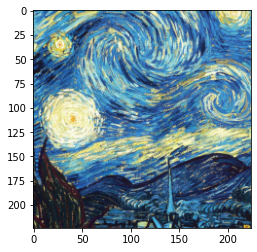

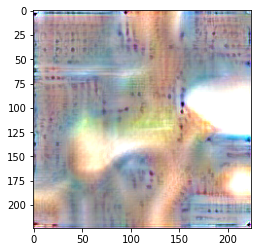

In [ ]:
# Estilo
for batch in style_loader:
  batch=batch.to(device)
  for img in batch:
    tensor_imshow(img.cpu())
    features_1_estilo=vgg16_1_capa(batch)
  break

# Salida 3

recon_2=recon_2.to(device)
for img in recon_2:
  tensor_imshow(img.cpu().detach())
  features_1_contenido=vgg16_1_capa(recon_2)

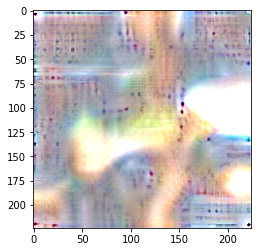

In [ ]:
# WCT
st_1=wct(alfa, features_1_contenido, features_1_estilo)[0];

# Reconstrucción
recon_1=decoder_1_capa(st_1)
for img_contenido in recon_1:
  tensor_imshow(img_contenido.cpu().detach())

# Referencias


Ref 1: Li, Y., Fang, C., Yang, J., Wang, Z., Lu, X., & Yang, M. H. (2017). Universal style transfer via feature transforms. In Advances in neural information processing systems (pp. 386-396). https://arxiv.org/abs/1705.08086
Ref 2: Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. https://arxiv.org/abs/1508.06576
Ref 3: PyTorch implementation of "Universal Style Transfer via Feature Transforms":
https://github.com/pietrocarbo/deep-transfer
Ref 4: Simonyan, K., Zisserman, A. (2014). Very Deep Convolutional Networks for Large Scale Image Recognition. https://arxiv.org/abs/1409.1556
Ref 5: Transferencia de aprendizaje y ajuste
https://www.tensorflow.org/tutorials/images/transfer_learning
Ref 6: COCO: Common Objects in Context
https://cocodataset.org/


# Decoders

[Decoder 1](https://colab.research.google.com/drive/1zrqmxLmSMdeY_wTg8oVBx8e6elHM6cpT?usp=sharing)
[Decoder 3](https://colab.research.google.com/drive/1U4PwKVqdqblJNX4krRFu-vxk1JElcY-P?usp=sharing)